In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#change to your datapath
%cd /content/drive/MyDrive/Colab Notebooks/AI_lab3

/content/drive/MyDrive/Colab Notebooks/AI_lab3


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
import os
import numpy as np
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
from resnet18 import *

In [4]:
# Create SummaryWriter
writer = SummaryWriter("../tensorboard")

In [30]:
#檢查是否可用gpu
print(torch.cuda.is_available())

True


# Baseline
## EPOCH = 40
## pre_epoch = 0
## BATCH_SIZE = 128
## lr = 0.05

## Train loss: 0.002 | Train acc: 1.000
## Val loss: 0.458 | Val acc: 0.864
## Test loss: 0.473 | Test acc: 0.863

In [31]:
# setting parameter
EPOCH = 40
pre_epoch = 0
BATCH_SIZE = 128
lr = 0.05
device = torch.device("cuda")

In [32]:
# 計算normalization需要的mean & std
def get_mean_std(dataset, ratio=0.3):
    # Get mean and std by sample ratio
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=int(len(dataset)*ratio), shuffle=True, num_workers=2)

    data = next(iter(dataloader))[0]     # get the first iteration data
    mean = np.mean(data.numpy(), axis=(0,2,3))
    std = np.std(data.numpy(), axis=(0,2,3))
    return mean, std

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_mean, train_std = get_mean_std(train_dataset)
test_mean, test_std = train_mean, train_std
print(train_mean, train_std)
print(test_mean, test_std)

Files already downloaded and verified
Files already downloaded and verified
[0.49176827 0.48268962 0.44647467] [0.24664469 0.2432167  0.26168513]
[0.49176827 0.48268962 0.44647467] [0.24664469 0.2432167  0.26168513]


In [33]:
# data augmentation & normalization
transform_train = transforms.Compose([
    # data augmentation


    transforms.ToTensor(),
    # data normalization    # standardization: (image - train_mean) / train_std

])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    # data normalization    # standardization: (image - train_mean) / train_std

])

In [34]:
# dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_ds = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# 檢查training dataset長怎麼樣
#print("trainset length: ", len(trainset))
#print("classes: ", trainset.classes)
#image, label = trainset[0]
#print("image shape: ", image.shape)
#print("label: ", label)

# Cifar-10的標籤: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# split validation dataset
torch.manual_seed(43)     # 確保每次獲得相同的驗證集
val_size = 5000       # 取5000張驗證集(0.1 of trainset)
train_size = len(trainset) - val_size
train_ds, val_ds = random_split(trainset, [train_size, val_size])
print("train length: ", len(train_ds))
print("val length: ", len(val_ds))
print("test length: ", len(test_ds))

trainloader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)   #生成batch
valloader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
train length:  45000
val length:  5000
test length:  10000


In [35]:
# learning rate shedule
def adjust_learning_rate(optim, epoch):
    # define your lr scheduler



    for param_group in optim.param_groups:
        param_group['lr'] = lr

In [ ]:
#是否pretrain
#import torchvision.models as models
#net = models.resnet18(pretrained = False).to(device)
net = ResNet(ResBlock).to(device)

# 定義損失函數和優化方式
criterion = nn.CrossEntropyLoss()  #loss function
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4) #優化方式為mini-batch momentum-SGD，採用L2正則化（權重衰減）
schecdular = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.5,last_epoch=-1)
# train
if __name__ == "__main__":
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []
    for epoch in range(pre_epoch, EPOCH):
        net.train()
        sum1_loss, sum2_loss = 0.0, 0.0
        correct = 0.0
        total = 0.0
        print('\nEpoch: %d' % (epoch + 1))
        for i, traindata in enumerate(trainloader, 0):
            # prepare data
            length = len(trainloader)
            inputs, train_labels = traindata
            inputs, train_labels = inputs.to(device), train_labels.to(device)
            optimizer.zero_grad()

            # forward + backward
            train_outputs = net(inputs)
            trainloss = criterion(train_outputs, train_labels)
            trainloss.backward()
            optimizer.step()

            # 每訓練1個batch的loss和acc
            sum1_loss += trainloss.item()
            _, predicted = torch.max(train_outputs.data, 1)     # 取得分數最高的那個類 (outputs.data的index), train_outputs.data.shape is torch.Size([128, 10])
            # print(torch.max(train_outputs.data, 1)[1])
            total += train_labels.size(0)
            correct += predicted.eq(train_labels.data).cpu().sum()


        schecdular.step()
        writer.add_scalar("lr", optimizer.param_groups[0]['lr'], epoch)
        # adjust_learning_rate(optimizer, epoch)
        print("learning rate: ",  optimizer.param_groups[0]['lr'])

        loss1 = sum1_loss / (i + 1) # i is equal to number of batches
        acc1 = correct / total
        print("Train loss: %.3f | Train acc: %.3f" % (loss1, acc1))
        train_loss.append(loss1)
        train_acc.append(acc1.item())

        # 每個epoch完用val驗證
        with torch.no_grad():
            correct = 0
            total = 0
            for j, valdata in enumerate(valloader, 0):
                net.eval()
                images, val_labels = valdata
                images, val_labels = images.to(device), val_labels.to(device)
                val_outputs = net(images)
                valloss = criterion(val_outputs, val_labels)

                sum2_loss += valloss.item()
                _, predicted = torch.max(val_outputs.data, 1)
                total += val_labels.size(0)
                correct += (predicted == val_labels).sum()

            loss2 = sum2_loss / (j + 1)
            acc2 = correct / total
            print("Val loss: %.3f | Val acc: %.3f" % (loss2, acc2))
            val_loss.append(loss2)
            val_acc.append(acc2.item())

    # 用test測試
    with torch.no_grad():
        correct = 0
        total = 0
        sum3_loss = 0.0
        for k, testdata in enumerate(testloader, 0):
            net.eval()
            imgs, test_labels = testdata
            imgs, test_labels = imgs.to(device), test_labels.to(device)
            test_outputs = net(imgs)
            testloss = criterion(test_outputs, test_labels)

            sum3_loss += testloss.item()
            _, predicted = torch.max(test_outputs.data, 1)
            total += test_labels.size(0)
            correct += (predicted == test_labels).sum()

        loss3 = sum3_loss / (k + 1)
        acc3 = correct / total
        print("Test loss: %.3f | Test acc: %.3f" % (loss3, acc3))


Epoch: 1
learning rate:  0.05
Train loss: 1.548 | Train acc: 0.437
Val loss: 1.525 | Val acc: 0.473

Epoch: 2
learning rate:  0.05
Train loss: 1.007 | Train acc: 0.641
Val loss: 1.027 | Val acc: 0.649

Epoch: 3
learning rate:  0.05
Train loss: 0.742 | Train acc: 0.740
Val loss: 0.809 | Val acc: 0.725

Epoch: 4
learning rate:  0.05
Train loss: 0.583 | Train acc: 0.796
Val loss: 0.782 | Val acc: 0.734

Epoch: 5
learning rate:  0.05
Train loss: 0.477 | Train acc: 0.834
Val loss: 0.731 | Val acc: 0.751

Epoch: 6
learning rate:  0.05
Train loss: 0.394 | Train acc: 0.862
Val loss: 0.653 | Val acc: 0.783

Epoch: 7
learning rate:  0.05
Train loss: 0.314 | Train acc: 0.888
Val loss: 0.764 | Val acc: 0.755

Epoch: 8
learning rate:  0.05
Train loss: 0.251 | Train acc: 0.910
Val loss: 0.665 | Val acc: 0.790

Epoch: 9
learning rate:  0.05
Train loss: 0.204 | Train acc: 0.928
Val loss: 0.582 | Val acc: 0.808

Epoch: 10
learning rate:  0.025
Train loss: 0.164 | Train acc: 0.942
Val loss: 0.775 | Val

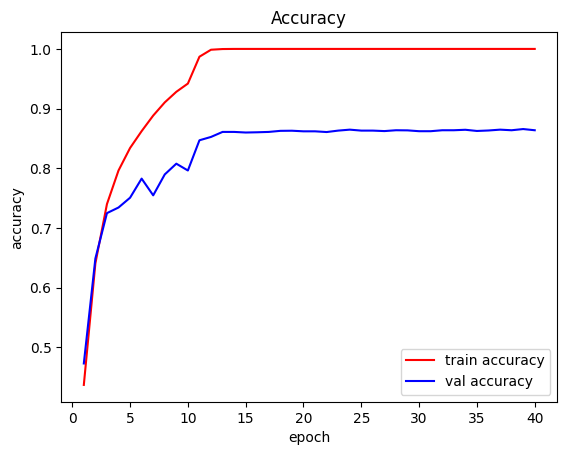

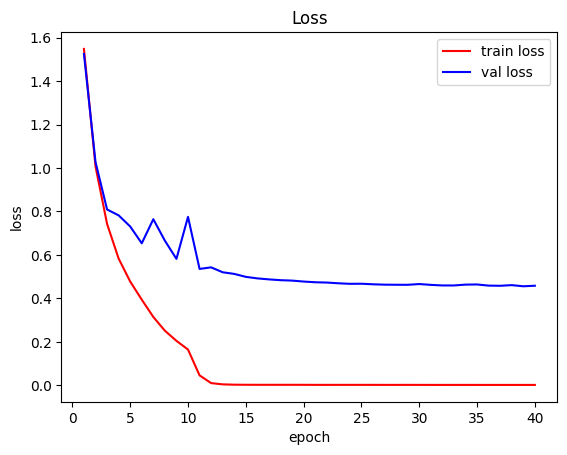

In [ ]:
import matplotlib.pyplot as plt
# plot accuracy curve
plt.figure(0)
plt.plot(range(1,EPOCH+1,1), np.array(train_acc), 'r-', label= "train accuracy")
plt.plot(range(1,EPOCH+1,1), np.array(val_acc), 'b-', label= "val accuracy")
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
#plt.ylim(0.6, 1.1)
plt.legend()
plt.show()

# plot loss curve
plt.figure(1)
plt.plot(range(1,EPOCH+1,1), np.array(train_loss), 'r-', label= "train loss")
plt.plot(range(1,EPOCH+1,1), np.array(val_loss), 'b-', label= "val loss")
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# Baseline + Image Normalize

## EPOCH = 40
## pre_epoch = 0
## BATCH_SIZE = 128
## lr = 0.05


## Train loss: 0.002 | Train acc: 1.000
## Val loss: 0.432 | Val acc: 0.862
## Test loss: 0.461 | Test acc: 0.866


In [ ]:
# setting parameter
EPOCH = 40
pre_epoch = 0
BATCH_SIZE = 128
lr = 0.05
device = torch.device("cuda")

In [ ]:

mean= [0.49260563, 0.48348528, 0.44855368] #RGB
std= [0.2467772,  0.24288093, 0.26137766]
# data augmentation & normalization
transform_train = transforms.Compose([
    # data augmentation


    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    # data normalization    # standardization: (image - train_mean) / train_std

])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    # data normalization    # standardization: (image - train_mean) / train_std

])

In [ ]:
# dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_ds = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# 檢查training dataset長怎麼樣
#print("trainset length: ", len(trainset))
#print("classes: ", trainset.classes)
#image, label = trainset[0]
#print("image shape: ", image.shape)
#print("label: ", label)

# Cifar-10的標籤: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# split validation dataset
torch.manual_seed(43)     # 確保每次獲得相同的驗證集
val_size = 5000       # 取5000張驗證集(0.1 of trainset)
train_size = len(trainset) - val_size
train_ds, val_ds = random_split(trainset, [train_size, val_size])
print("train length: ", len(train_ds))
print("val length: ", len(val_ds))
print("test length: ", len(test_ds))

trainloader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)   #生成batch
valloader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
train length:  45000
val length:  5000
test length:  10000


In [ ]:
# learning rate shedule
def adjust_learning_rate(optim, epoch):
    # define your lr scheduler



    for param_group in optim.param_groups:
        param_group['lr'] = lr

In [ ]:
#是否pretrain
#import torchvision.models as models
#net = models.resnet18(pretrained = False).to(device)
net = ResNet(ResBlock).to(device)

# 定義損失函數和優化方式
criterion = nn.CrossEntropyLoss()  #loss function
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4) #優化方式為mini-batch momentum-SGD，採用L2正則化（權重衰減）
schecdular = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.5,last_epoch=-1)
# train
if __name__ == "__main__":
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []
    for epoch in range(pre_epoch, EPOCH):
        net.train()
        sum1_loss, sum2_loss = 0.0, 0.0
        correct = 0.0
        total = 0.0
        print('\nEpoch: %d' % (epoch + 1))
        for i, traindata in enumerate(trainloader, 0):
            # prepare data
            length = len(trainloader)
            inputs, train_labels = traindata
            inputs, train_labels = inputs.to(device), train_labels.to(device)
            optimizer.zero_grad()

            # forward + backward
            train_outputs = net(inputs)
            trainloss = criterion(train_outputs, train_labels)
            trainloss.backward()
            optimizer.step()

            # 每訓練1個batch的loss和acc
            sum1_loss += trainloss.item()
            _, predicted = torch.max(train_outputs.data, 1)     # 取得分數最高的那個類 (outputs.data的index), train_outputs.data.shape is torch.Size([128, 10])
            # print(torch.max(train_outputs.data, 1)[1])
            total += train_labels.size(0)
            correct += predicted.eq(train_labels.data).cpu().sum()


        schecdular.step()
        writer.add_scalar("lr", optimizer.param_groups[0]['lr'], epoch)
        # adjust_learning_rate(optimizer, epoch)
        print("learning rate: ",  optimizer.param_groups[0]['lr'])

        loss1 = sum1_loss / (i + 1) # i is equal to number of batches
        acc1 = correct / total
        print("Train loss: %.3f | Train acc: %.3f" % (loss1, acc1))
        train_loss.append(loss1)
        train_acc.append(acc1.item())

        # 每個epoch完用val驗證
        with torch.no_grad():
            correct = 0
            total = 0
            for j, valdata in enumerate(valloader, 0):
                net.eval()
                images, val_labels = valdata
                images, val_labels = images.to(device), val_labels.to(device)
                val_outputs = net(images)
                valloss = criterion(val_outputs, val_labels)

                sum2_loss += valloss.item()
                _, predicted = torch.max(val_outputs.data, 1)
                total += val_labels.size(0)
                correct += (predicted == val_labels).sum()

            loss2 = sum2_loss / (j + 1)
            acc2 = correct / total
            print("Val loss: %.3f | Val acc: %.3f" % (loss2, acc2))
            val_loss.append(loss2)
            val_acc.append(acc2.item())

    # 用test測試
    with torch.no_grad():
        correct = 0
        total = 0
        sum3_loss = 0.0
        for k, testdata in enumerate(testloader, 0):
            net.eval()
            imgs, test_labels = testdata
            imgs, test_labels = imgs.to(device), test_labels.to(device)
            test_outputs = net(imgs)
            testloss = criterion(test_outputs, test_labels)

            sum3_loss += testloss.item()
            _, predicted = torch.max(test_outputs.data, 1)
            total += test_labels.size(0)
            correct += (predicted == test_labels).sum()

        loss3 = sum3_loss / (k + 1)
        acc3 = correct / total
        print("Test loss: %.3f | Test acc: %.3f" % (loss3, acc3))


Epoch: 1
learning rate:  0.05
Train loss: 1.595 | Train acc: 0.418
Val loss: 1.459 | Val acc: 0.476

Epoch: 2
learning rate:  0.05
Train loss: 1.039 | Train acc: 0.626
Val loss: 1.136 | Val acc: 0.589

Epoch: 3
learning rate:  0.05
Train loss: 0.785 | Train acc: 0.723
Val loss: 0.791 | Val acc: 0.720

Epoch: 4
learning rate:  0.05
Train loss: 0.610 | Train acc: 0.786
Val loss: 0.709 | Val acc: 0.754

Epoch: 5
learning rate:  0.05
Train loss: 0.495 | Train acc: 0.826
Val loss: 0.701 | Val acc: 0.758

Epoch: 6
learning rate:  0.05
Train loss: 0.401 | Train acc: 0.860
Val loss: 0.616 | Val acc: 0.791

Epoch: 7
learning rate:  0.05
Train loss: 0.327 | Train acc: 0.885
Val loss: 0.815 | Val acc: 0.752

Epoch: 8
learning rate:  0.05
Train loss: 0.262 | Train acc: 0.906
Val loss: 0.659 | Val acc: 0.782

Epoch: 9
learning rate:  0.05
Train loss: 0.208 | Train acc: 0.927
Val loss: 0.620 | Val acc: 0.802

Epoch: 10
learning rate:  0.025
Train loss: 0.175 | Train acc: 0.938
Val loss: 0.695 | Val

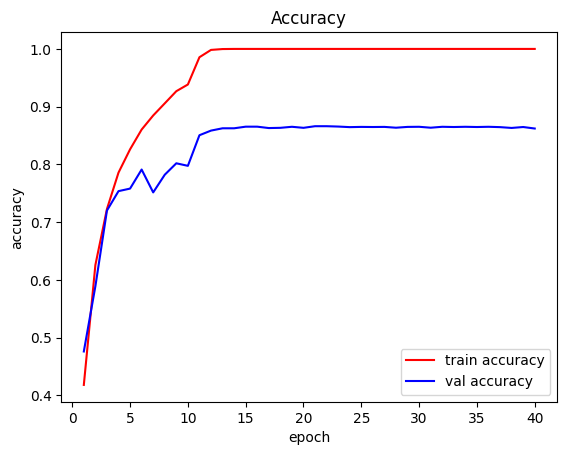

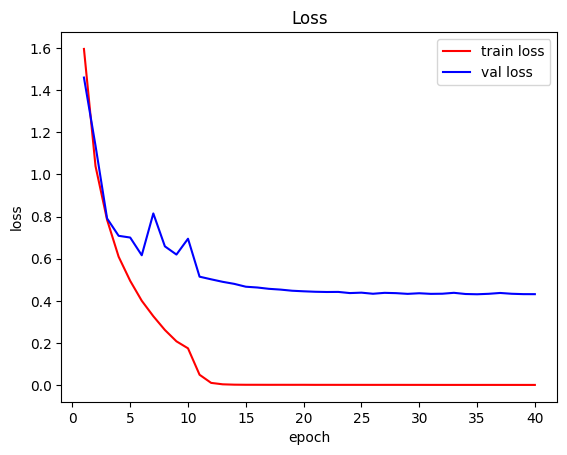

In [ ]:
import matplotlib.pyplot as plt
# plot accuracy curve
plt.figure(0)
plt.plot(range(1,EPOCH+1,1), np.array(train_acc), 'r-', label= "train accuracy")
plt.plot(range(1,EPOCH+1,1), np.array(val_acc), 'b-', label= "val accuracy")
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
#plt.ylim(0.6, 1.1)
plt.legend()
plt.show()

# plot loss curve
plt.figure(1)
plt.plot(range(1,EPOCH+1,1), np.array(train_loss), 'r-', label= "train loss")
plt.plot(range(1,EPOCH+1,1), np.array(val_loss), 'b-', label= "val loss")
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# Baseline + data augmentation

## EPOCH = 40
## pre_epoch = 0
## BATCH_SIZE = 128
## lr = 0.05


## Train loss: 0.024 | Train acc: 0.992
## Val loss: 0.309 | Val acc: 0.914
## Test loss: 0.315 | Test acc: 0.920

In [ ]:
# setting parameter
EPOCH = 40
pre_epoch = 0
BATCH_SIZE = 128
lr = 0.05
device = torch.device("cuda")

In [ ]:
# data augmentation & normalization
transform_train = transforms.Compose([
    # data augmentation
    transforms.RandomCrop(32, padding=4), #隨機採剪 size裁剪的输出的尺寸 padding填充像素数量
    transforms.RandomHorizontalFlip(),   #隨機水平翻轉
    transforms.ToTensor(),
    # data normalization    # standardization: (image - train_mean) / train_std

])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    # data normalization    # standardization: (image - train_mean) / train_std

])

In [ ]:
# dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_ds = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# 檢查training dataset長怎麼樣
#print("trainset length: ", len(trainset))
#print("classes: ", trainset.classes)
#image, label = trainset[0]
#print("image shape: ", image.shape)
#print("label: ", label)

# Cifar-10的標籤: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# split validation dataset
torch.manual_seed(43)     # 確保每次獲得相同的驗證集
val_size = 5000       # 取5000張驗證集(0.1 of trainset)
train_size = len(trainset) - val_size
train_ds, val_ds = random_split(trainset, [train_size, val_size])
print("train length: ", len(train_ds))
print("val length: ", len(val_ds))
print("test length: ", len(test_ds))

trainloader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)   #生成batch
valloader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
train length:  45000
val length:  5000
test length:  10000


In [ ]:
# learning rate shedule
def adjust_learning_rate(optim, epoch):
    # define your lr scheduler



    for param_group in optim.param_groups:
        param_group['lr'] = lr

In [ ]:
#是否pretrain
#import torchvision.models as models
#net = models.resnet18(pretrained = False).to(device)
net = ResNet(ResBlock).to(device)

# 定義損失函數和優化方式
criterion = nn.CrossEntropyLoss()  #loss function
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4) #優化方式為mini-batch momentum-SGD，採用L2正則化（權重衰減）
schecdular = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.5,last_epoch=-1)
# train
if __name__ == "__main__":
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []
    for epoch in range(pre_epoch, EPOCH):
        net.train()
        sum1_loss, sum2_loss = 0.0, 0.0
        correct = 0.0
        total = 0.0
        print('\nEpoch: %d' % (epoch + 1))
        for i, traindata in enumerate(trainloader, 0):
            # prepare data
            length = len(trainloader)
            inputs, train_labels = traindata
            inputs, train_labels = inputs.to(device), train_labels.to(device)
            optimizer.zero_grad()

            # forward + backward
            train_outputs = net(inputs)
            trainloss = criterion(train_outputs, train_labels)
            trainloss.backward()
            optimizer.step()

            # 每訓練1個batch的loss和acc
            sum1_loss += trainloss.item()
            _, predicted = torch.max(train_outputs.data, 1)     # 取得分數最高的那個類 (outputs.data的index), train_outputs.data.shape is torch.Size([128, 10])
            # print(torch.max(train_outputs.data, 1)[1])
            total += train_labels.size(0)
            correct += predicted.eq(train_labels.data).cpu().sum()


        schecdular.step()
        writer.add_scalar("lr", optimizer.param_groups[0]['lr'], epoch)
        # adjust_learning_rate(optimizer, epoch)
        print("learning rate: ",  optimizer.param_groups[0]['lr'])

        loss1 = sum1_loss / (i + 1) # i is equal to number of batches
        acc1 = correct / total
        print("Train loss: %.3f | Train acc: %.3f" % (loss1, acc1))
        train_loss.append(loss1)
        train_acc.append(acc1.item())

        # 每個epoch完用val驗證
        with torch.no_grad():
            correct = 0
            total = 0
            for j, valdata in enumerate(valloader, 0):
                net.eval()
                images, val_labels = valdata
                images, val_labels = images.to(device), val_labels.to(device)
                val_outputs = net(images)
                valloss = criterion(val_outputs, val_labels)

                sum2_loss += valloss.item()
                _, predicted = torch.max(val_outputs.data, 1)
                total += val_labels.size(0)
                correct += (predicted == val_labels).sum()

            loss2 = sum2_loss / (j + 1)
            acc2 = correct / total
            print("Val loss: %.3f | Val acc: %.3f" % (loss2, acc2))
            val_loss.append(loss2)
            val_acc.append(acc2.item())

    # 用test測試
    with torch.no_grad():
        correct = 0
        total = 0
        sum3_loss = 0.0
        for k, testdata in enumerate(testloader, 0):
            net.eval()
            imgs, test_labels = testdata
            imgs, test_labels = imgs.to(device), test_labels.to(device)
            test_outputs = net(imgs)
            testloss = criterion(test_outputs, test_labels)

            sum3_loss += testloss.item()
            _, predicted = torch.max(test_outputs.data, 1)
            total += test_labels.size(0)
            correct += (predicted == test_labels).sum()

        loss3 = sum3_loss / (k + 1)
        acc3 = correct / total
        print("Test loss: %.3f | Test acc: %.3f" % (loss3, acc3))


Epoch: 1
learning rate:  0.05
Train loss: 1.726 | Train acc: 0.369
Val loss: 1.798 | Val acc: 0.384

Epoch: 2
learning rate:  0.05
Train loss: 1.230 | Train acc: 0.554
Val loss: 1.720 | Val acc: 0.407

Epoch: 3
learning rate:  0.05
Train loss: 0.973 | Train acc: 0.654
Val loss: 0.975 | Val acc: 0.643

Epoch: 4
learning rate:  0.05
Train loss: 0.802 | Train acc: 0.717
Val loss: 1.086 | Val acc: 0.625

Epoch: 5
learning rate:  0.05
Train loss: 0.683 | Train acc: 0.761
Val loss: 0.919 | Val acc: 0.685

Epoch: 6
learning rate:  0.05
Train loss: 0.595 | Train acc: 0.794
Val loss: 0.785 | Val acc: 0.731

Epoch: 7
learning rate:  0.05
Train loss: 0.536 | Train acc: 0.814
Val loss: 0.646 | Val acc: 0.777

Epoch: 8
learning rate:  0.05
Train loss: 0.491 | Train acc: 0.831
Val loss: 0.641 | Val acc: 0.782

Epoch: 9
learning rate:  0.05
Train loss: 0.451 | Train acc: 0.843
Val loss: 0.978 | Val acc: 0.672

Epoch: 10
learning rate:  0.025
Train loss: 0.426 | Train acc: 0.853
Val loss: 0.705 | Val

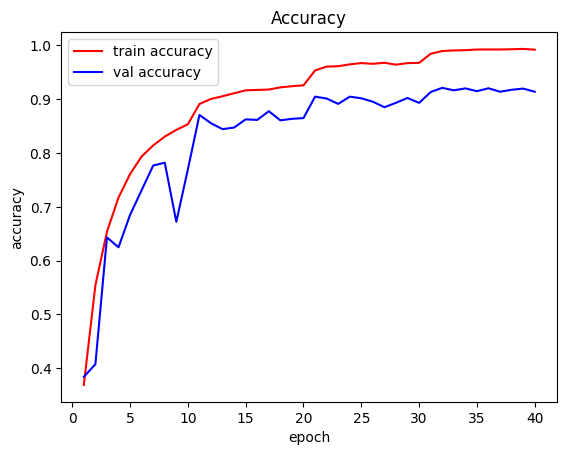

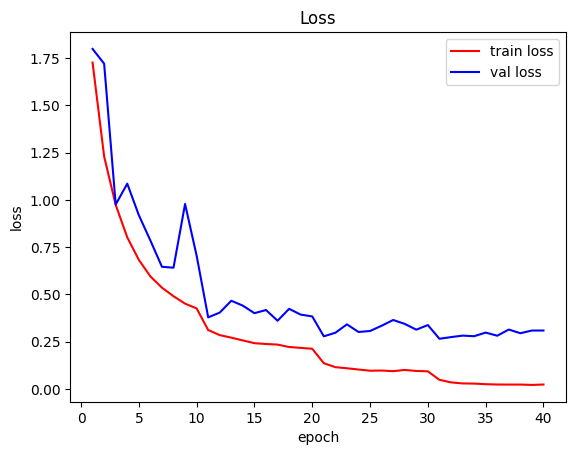

In [ ]:
import matplotlib.pyplot as plt
# plot accuracy curve
plt.figure(0)
plt.plot(range(1,EPOCH+1,1), np.array(train_acc), 'r-', label= "train accuracy")
plt.plot(range(1,EPOCH+1,1), np.array(val_acc), 'b-', label= "val accuracy")
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
#plt.ylim(0.6, 1.1)
plt.legend()
plt.show()

# plot loss curve
plt.figure(1)
plt.plot(range(1,EPOCH+1,1), np.array(train_loss), 'r-', label= "train loss")
plt.plot(range(1,EPOCH+1,1), np.array(val_loss), 'b-', label= "val loss")
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# Baseline + normalization + data augmentation

## EPOCH = 40
## pre_epoch = 0
## BATCH_SIZE = 128
## lr = 0.05

## Train loss: 0.025 | Train acc: 0.993
## Val loss: 0.320 | Val acc: 0.916
## Test loss: 0.316 | Test acc: 0.917

In [ ]:
# setting parameter
EPOCH = 40
pre_epoch = 0
BATCH_SIZE = 128
lr = 0.05
device = torch.device("cuda")

In [ ]:
# data augmentation & normalization
mean= [0.49260563, 0.48348528, 0.44855368] #RGB
std= [0.2467772,  0.24288093, 0.26137766]
transform_train = transforms.Compose([
    # data augmentation
    transforms.RandomCrop(32, padding=4), #隨機採剪
    transforms.RandomHorizontalFlip(),   #隨機水平翻轉
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    # data normalization    # standardization: (image - train_mean) / train_std

])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    # data normalization    # standardization: (image - train_mean) / train_std

])

In [ ]:
# dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_ds = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# 檢查training dataset長怎麼樣
#print("trainset length: ", len(trainset))
#print("classes: ", trainset.classes)
#image, label = trainset[0]
#print("image shape: ", image.shape)
#print("label: ", label)

# Cifar-10的標籤: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# split validation dataset
torch.manual_seed(43)     # 確保每次獲得相同的驗證集
val_size = 5000       # 取5000張驗證集(0.1 of trainset)
train_size = len(trainset) - val_size
train_ds, val_ds = random_split(trainset, [train_size, val_size])
print("train length: ", len(train_ds))
print("val length: ", len(val_ds))
print("test length: ", len(test_ds))

trainloader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)   #生成batch
valloader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
train length:  45000
val length:  5000
test length:  10000


In [ ]:
# learning rate shedule
def adjust_learning_rate(optim, epoch):
    # define your lr scheduler



    for param_group in optim.param_groups:
        param_group['lr'] = lr

In [ ]:
#是否pretrain
#import torchvision.models as models
#net = models.resnet18(pretrained = False).to(device)
net = ResNet(ResBlock).to(device)

# 定義損失函數和優化方式
criterion = nn.CrossEntropyLoss()  #loss function
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4) #優化方式為mini-batch momentum-SGD，採用L2正則化（權重衰減）
schecdular = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.5,last_epoch=-1)
# train
if __name__ == "__main__":
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []
    for epoch in range(pre_epoch, EPOCH):
        net.train()
        sum1_loss, sum2_loss = 0.0, 0.0
        correct = 0.0
        total = 0.0
        print('\nEpoch: %d' % (epoch + 1))
        for i, traindata in enumerate(trainloader, 0):
            # prepare data
            length = len(trainloader)
            inputs, train_labels = traindata
            inputs, train_labels = inputs.to(device), train_labels.to(device)
            optimizer.zero_grad()

            # forward + backward
            train_outputs = net(inputs)
            trainloss = criterion(train_outputs, train_labels)
            trainloss.backward()
            optimizer.step()

            # 每訓練1個batch的loss和acc
            sum1_loss += trainloss.item()
            _, predicted = torch.max(train_outputs.data, 1)     # 取得分數最高的那個類 (outputs.data的index), train_outputs.data.shape is torch.Size([128, 10])
            # print(torch.max(train_outputs.data, 1)[1])
            total += train_labels.size(0)
            correct += predicted.eq(train_labels.data).cpu().sum()


        schecdular.step()
        writer.add_scalar("lr", optimizer.param_groups[0]['lr'], epoch)
        # adjust_learning_rate(optimizer, epoch)
        print("learning rate: ",  optimizer.param_groups[0]['lr'])

        loss1 = sum1_loss / (i + 1) # i is equal to number of batches
        acc1 = correct / total
        print("Train loss: %.3f | Train acc: %.3f" % (loss1, acc1))
        train_loss.append(loss1)
        train_acc.append(acc1.item())

        # 每個epoch完用val驗證
        with torch.no_grad():
            correct = 0
            total = 0
            for j, valdata in enumerate(valloader, 0):
                net.eval()
                images, val_labels = valdata
                images, val_labels = images.to(device), val_labels.to(device)
                val_outputs = net(images)
                valloss = criterion(val_outputs, val_labels)

                sum2_loss += valloss.item()
                _, predicted = torch.max(val_outputs.data, 1)
                total += val_labels.size(0)
                correct += (predicted == val_labels).sum()

            loss2 = sum2_loss / (j + 1)
            acc2 = correct / total
            print("Val loss: %.3f | Val acc: %.3f" % (loss2, acc2))
            val_loss.append(loss2)
            val_acc.append(acc2.item())

    # 用test測試
    with torch.no_grad():
        correct = 0
        total = 0
        sum3_loss = 0.0
        for k, testdata in enumerate(testloader, 0):
            net.eval()
            imgs, test_labels = testdata
            imgs, test_labels = imgs.to(device), test_labels.to(device)
            test_outputs = net(imgs)
            testloss = criterion(test_outputs, test_labels)

            sum3_loss += testloss.item()
            _, predicted = torch.max(test_outputs.data, 1)
            total += test_labels.size(0)
            correct += (predicted == test_labels).sum()

        loss3 = sum3_loss / (k + 1)
        acc3 = correct / total
        print("Test loss: %.3f | Test acc: %.3f" % (loss3, acc3))


Epoch: 1
learning rate:  0.05
Train loss: 1.759 | Train acc: 0.366
Val loss: 1.548 | Val acc: 0.435

Epoch: 2
learning rate:  0.05
Train loss: 1.257 | Train acc: 0.543
Val loss: 1.173 | Val acc: 0.586

Epoch: 3
learning rate:  0.05
Train loss: 1.010 | Train acc: 0.639
Val loss: 0.950 | Val acc: 0.660

Epoch: 4
learning rate:  0.05
Train loss: 0.845 | Train acc: 0.699
Val loss: 0.901 | Val acc: 0.684

Epoch: 5
learning rate:  0.05
Train loss: 0.720 | Train acc: 0.747
Val loss: 0.718 | Val acc: 0.746

Epoch: 6
learning rate:  0.05
Train loss: 0.632 | Train acc: 0.779
Val loss: 0.696 | Val acc: 0.759

Epoch: 7
learning rate:  0.05
Train loss: 0.570 | Train acc: 0.801
Val loss: 0.659 | Val acc: 0.771

Epoch: 8
learning rate:  0.05
Train loss: 0.520 | Train acc: 0.820
Val loss: 0.679 | Val acc: 0.763

Epoch: 9
learning rate:  0.05
Train loss: 0.472 | Train acc: 0.836
Val loss: 0.553 | Val acc: 0.812

Epoch: 10
learning rate:  0.025
Train loss: 0.439 | Train acc: 0.849
Val loss: 0.544 | Val

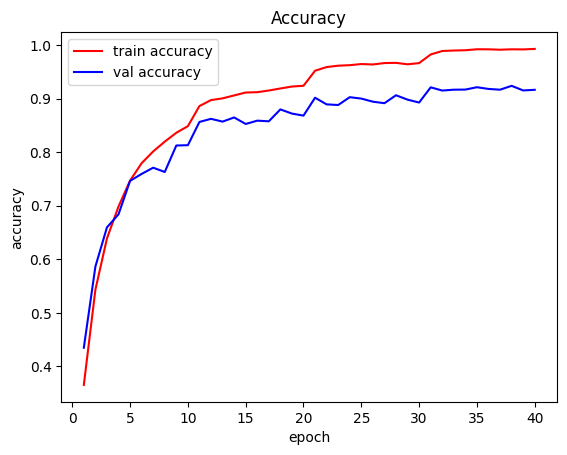

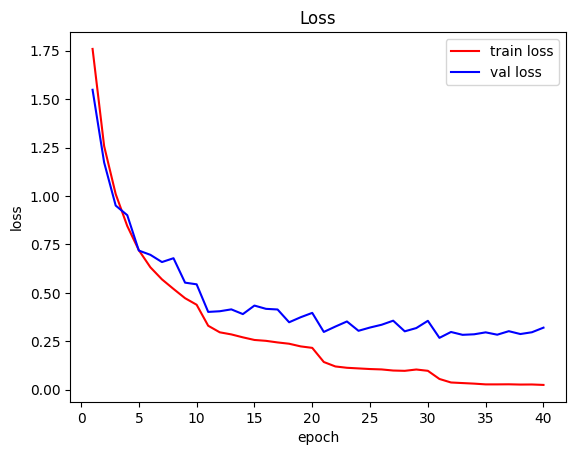

In [ ]:
import matplotlib.pyplot as plt
# plot accuracy curve
plt.figure(0)
plt.plot(range(1,EPOCH+1,1), np.array(train_acc), 'r-', label= "train accuracy")
plt.plot(range(1,EPOCH+1,1), np.array(val_acc), 'b-', label= "val accuracy")
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
#plt.ylim(0.6, 1.1)
plt.legend()
plt.show()

# plot loss curve
plt.figure(1)
plt.plot(range(1,EPOCH+1,1), np.array(train_loss), 'r-', label= "train loss")
plt.plot(range(1,EPOCH+1,1), np.array(val_loss), 'b-', label= "val loss")
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# Different base learning rate and update strategy
# Baseline + normalization + data augmentation

## EPOCH = 40
## pre_epoch = 0
## BATCH_SIZE = 128
## lr = 0.1, for epoch<10
## lr = 0.05, for 10<epoch<20
## lr = 0.01, for 20<epoch
----------------------------------------------------
##Train loss: 0.057 | Train acc: 0.981
##Val loss: 0.317 | Val acc: 0.903
##Test loss: 0.331 | Test acc: 0.909

In [ ]:
# setting parameter
EPOCH = 40
pre_epoch = 0
BATCH_SIZE = 128
lr = 0.01
device = torch.device("cuda")

In [ ]:
# data augmentation & normalization
mean= [0.49260563, 0.48348528, 0.44855368] #RGB
std= [0.2467772,  0.24288093, 0.26137766]
transform_train = transforms.Compose([
    # data augmentation
    transforms.RandomCrop(32, padding=4), #隨機採剪
    transforms.RandomHorizontalFlip(),   #隨機水平翻轉
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    # data normalization    # standardization: (image - train_mean) / train_std

])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    # data normalization    # standardization: (image - train_mean) / train_std

])

In [ ]:
# learning rate shedule
def adjust_learning_rate(optim, epoch):
    # define your lr scheduler
    if epoch < 10:
        lr = 0.1
    elif epoch < 20:
        lr = 0.05
    else:
        lr = 0.01

    for param_group in optim.param_groups:
        param_group['lr'] = lr

In [ ]:
#是否pretrain
#import torchvision.models as models
#net = models.resnet18(pretrained = False).to(device)
net = ResNet(ResBlock).to(device)

# 定義損失函數和優化方式
criterion = nn.CrossEntropyLoss()  #loss function
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4) #優化方式為mini-batch momentum-SGD，採用L2正則化（權重衰減）
schecdular = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.5,last_epoch=-1)
# train
if __name__ == "__main__":
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []
    for epoch in range(pre_epoch, EPOCH):
        net.train()
        sum1_loss, sum2_loss = 0.0, 0.0
        correct = 0.0
        total = 0.0
        print('\nEpoch: %d' % (epoch + 1))
        for i, traindata in enumerate(trainloader, 0):
            # prepare data
            length = len(trainloader)
            inputs, train_labels = traindata
            inputs, train_labels = inputs.to(device), train_labels.to(device)
            optimizer.zero_grad()

            # forward + backward
            train_outputs = net(inputs)
            trainloss = criterion(train_outputs, train_labels)
            trainloss.backward()
            optimizer.step()

            # 每訓練1個batch的loss和acc
            sum1_loss += trainloss.item()
            _, predicted = torch.max(train_outputs.data, 1)     # 取得分數最高的那個類 (outputs.data的index), train_outputs.data.shape is torch.Size([128, 10])
            # print(torch.max(train_outputs.data, 1)[1])
            total += train_labels.size(0)
            correct += predicted.eq(train_labels.data).cpu().sum()


        schecdular.step()
        writer.add_scalar("lr", optimizer.param_groups[0]['lr'], epoch)
        adjust_learning_rate(optimizer, epoch)
        print("learning rate: ",  optimizer.param_groups[0]['lr'])

        loss1 = sum1_loss / (i + 1) # i is equal to number of batches
        acc1 = correct / total
        print("Train loss: %.3f | Train acc: %.3f" % (loss1, acc1))
        train_loss.append(loss1)
        train_acc.append(acc1.item())

        # 每個epoch完用val驗證
        with torch.no_grad():
            correct = 0
            total = 0
            for j, valdata in enumerate(valloader, 0):
                net.eval()
                images, val_labels = valdata
                images, val_labels = images.to(device), val_labels.to(device)
                val_outputs = net(images)
                valloss = criterion(val_outputs, val_labels)

                sum2_loss += valloss.item()
                _, predicted = torch.max(val_outputs.data, 1)
                total += val_labels.size(0)
                correct += (predicted == val_labels).sum()

            loss2 = sum2_loss / (j + 1)
            acc2 = correct / total
            print("Val loss: %.3f | Val acc: %.3f" % (loss2, acc2))
            val_loss.append(loss2)
            val_acc.append(acc2.item())

    # 用test測試
    with torch.no_grad():
        correct = 0
        total = 0
        sum3_loss = 0.0
        for k, testdata in enumerate(testloader, 0):
            net.eval()
            imgs, test_labels = testdata
            imgs, test_labels = imgs.to(device), test_labels.to(device)
            test_outputs = net(imgs)
            testloss = criterion(test_outputs, test_labels)

            sum3_loss += testloss.item()
            _, predicted = torch.max(test_outputs.data, 1)
            total += test_labels.size(0)
            correct += (predicted == test_labels).sum()

        loss3 = sum3_loss / (k + 1)
        acc3 = correct / total
        print("Test loss: %.3f | Test acc: %.3f" % (loss3, acc3))


Epoch: 1
learning rate:  0.1
Train loss: 1.475 | Train acc: 0.460
Val loss: 1.335 | Val acc: 0.507

Epoch: 2
learning rate:  0.1
Train loss: 1.891 | Train acc: 0.319
Val loss: 1.604 | Val acc: 0.407

Epoch: 3
learning rate:  0.1
Train loss: 1.363 | Train acc: 0.500
Val loss: 1.327 | Val acc: 0.506

Epoch: 4
learning rate:  0.1
Train loss: 1.083 | Train acc: 0.612
Val loss: 1.028 | Val acc: 0.623

Epoch: 5
learning rate:  0.1
Train loss: 0.900 | Train acc: 0.682
Val loss: 0.925 | Val acc: 0.671

Epoch: 6
learning rate:  0.1
Train loss: 0.752 | Train acc: 0.735
Val loss: 0.835 | Val acc: 0.709

Epoch: 7
learning rate:  0.1
Train loss: 0.653 | Train acc: 0.773
Val loss: 0.749 | Val acc: 0.741

Epoch: 8
learning rate:  0.1
Train loss: 0.595 | Train acc: 0.794
Val loss: 0.724 | Val acc: 0.751

Epoch: 9
learning rate:  0.1
Train loss: 0.557 | Train acc: 0.809
Val loss: 0.787 | Val acc: 0.735

Epoch: 10
learning rate:  0.1
Train loss: 0.523 | Train acc: 0.820
Val loss: 0.653 | Val acc: 0.774

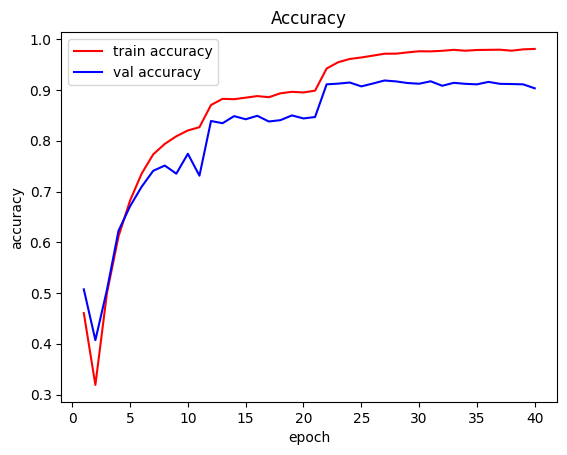

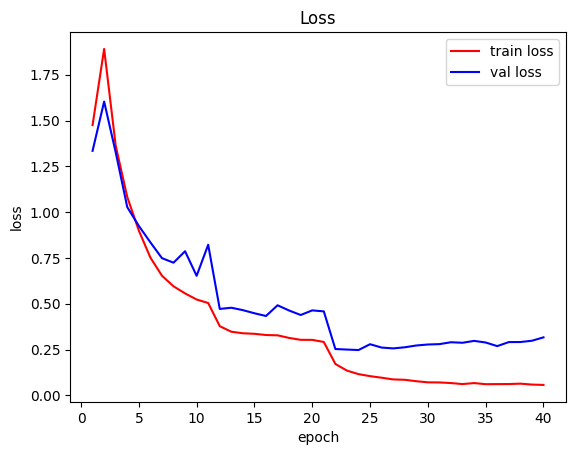

In [ ]:
import matplotlib.pyplot as plt
# plot accuracy curve
plt.figure(0)
plt.plot(range(1,EPOCH+1,1), np.array(train_acc), 'r-', label= "train accuracy")
plt.plot(range(1,EPOCH+1,1), np.array(val_acc), 'b-', label= "val accuracy")
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
#plt.ylim(0.6, 1.1)
plt.legend()
plt.show()

# plot loss curve
plt.figure(1)
plt.plot(range(1,EPOCH+1,1), np.array(train_loss), 'r-', label= "train loss")
plt.plot(range(1,EPOCH+1,1), np.array(val_loss), 'b-', label= "val loss")
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# Different batchsize (256)
# Different base learning rate and update strategy
# Baseline + normalization + data augmentation
## EPOCH = 40
## pre_epoch = 0
## BATCH_SIZE = 256
## lr = 0.1, for epoch<10
## lr = 0.05, for 10<epoch<20
## lr = 0.01, for 20<epoch

In [39]:
# setting parameter
EPOCH = 40
pre_epoch = 0
BATCH_SIZE = 256
lr = 0.01
device = torch.device("cuda")

In [40]:
# data augmentation & normalization
mean= [0.49260563, 0.48348528, 0.44855368] #RGB
std= [0.2467772,  0.24288093, 0.26137766]
transform_train = transforms.Compose([
    # data augmentation
    transforms.RandomCrop(32, padding=4), #隨機採剪
    transforms.RandomHorizontalFlip(),   #隨機水平翻轉
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    # data normalization    # standardization: (image - train_mean) / train_std

])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    # data normalization    # standardization: (image - train_mean) / train_std

])

In [41]:
# learning rate shedule
def adjust_learning_rate(optim, epoch):
    # define your lr scheduler
    if epoch < 10:
        lr = 0.1
    elif epoch < 20:
        lr = 0.05
    else:
        lr = 0.01

    for param_group in optim.param_groups:
        param_group['lr'] = lr

In [42]:
#是否pretrain
#import torchvision.models as models
#net = models.resnet18(pretrained = False).to(device)
net = ResNet(ResBlock).to(device)

# 定義損失函數和優化方式
criterion = nn.CrossEntropyLoss()  #loss function
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4) #優化方式為mini-batch momentum-SGD，採用L2正則化（權重衰減）
schecdular = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.5,last_epoch=-1)
# train
if __name__ == "__main__":
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []
    for epoch in range(pre_epoch, EPOCH):
        net.train()
        sum1_loss, sum2_loss = 0.0, 0.0
        correct = 0.0
        total = 0.0
        print('\nEpoch: %d' % (epoch + 1))
        for i, traindata in enumerate(trainloader, 0):
            # prepare data
            length = len(trainloader)
            inputs, train_labels = traindata
            inputs, train_labels = inputs.to(device), train_labels.to(device)
            optimizer.zero_grad()

            # forward + backward
            train_outputs = net(inputs)
            trainloss = criterion(train_outputs, train_labels)
            trainloss.backward()
            optimizer.step()

            # 每訓練1個batch的loss和acc
            sum1_loss += trainloss.item()
            _, predicted = torch.max(train_outputs.data, 1)     # 取得分數最高的那個類 (outputs.data的index), train_outputs.data.shape is torch.Size([128, 10])
            # print(torch.max(train_outputs.data, 1)[1])
            total += train_labels.size(0)
            correct += predicted.eq(train_labels.data).cpu().sum()


        schecdular.step()
        writer.add_scalar("lr", optimizer.param_groups[0]['lr'], epoch)
        adjust_learning_rate(optimizer, epoch)
        print("learning rate: ",  optimizer.param_groups[0]['lr'])

        loss1 = sum1_loss / (i + 1) # i is equal to number of batches
        acc1 = correct / total
        print("Train loss: %.3f | Train acc: %.3f" % (loss1, acc1))
        train_loss.append(loss1)
        train_acc.append(acc1.item())

        # 每個epoch完用val驗證
        with torch.no_grad():
            correct = 0
            total = 0
            for j, valdata in enumerate(valloader, 0):
                net.eval()
                images, val_labels = valdata
                images, val_labels = images.to(device), val_labels.to(device)
                val_outputs = net(images)
                valloss = criterion(val_outputs, val_labels)

                sum2_loss += valloss.item()
                _, predicted = torch.max(val_outputs.data, 1)
                total += val_labels.size(0)
                correct += (predicted == val_labels).sum()

            loss2 = sum2_loss / (j + 1)
            acc2 = correct / total
            print("Val loss: %.3f | Val acc: %.3f" % (loss2, acc2))
            val_loss.append(loss2)
            val_acc.append(acc2.item())

    # 用test測試
    with torch.no_grad():
        correct = 0
        total = 0
        sum3_loss = 0.0
        for k, testdata in enumerate(testloader, 0):
            net.eval()
            imgs, test_labels = testdata
            imgs, test_labels = imgs.to(device), test_labels.to(device)
            test_outputs = net(imgs)
            testloss = criterion(test_outputs, test_labels)

            sum3_loss += testloss.item()
            _, predicted = torch.max(test_outputs.data, 1)
            total += test_labels.size(0)
            correct += (predicted == test_labels).sum()

        loss3 = sum3_loss / (k + 1)
        acc3 = correct / total
        print("Test loss: %.3f | Test acc: %.3f" % (loss3, acc3))


Epoch: 1
learning rate:  0.1
Train loss: 1.335 | Train acc: 0.515
Val loss: 1.201 | Val acc: 0.570

Epoch: 2
learning rate:  0.1
Train loss: 1.945 | Train acc: 0.313
Val loss: 1.530 | Val acc: 0.427

Epoch: 3
learning rate:  0.1
Train loss: 1.307 | Train acc: 0.522
Val loss: 1.405 | Val acc: 0.520

Epoch: 4
learning rate:  0.1
Train loss: 0.991 | Train acc: 0.647
Val loss: 1.060 | Val acc: 0.626

Epoch: 5
learning rate:  0.1
Train loss: 0.762 | Train acc: 0.732
Val loss: 1.266 | Val acc: 0.607

Epoch: 6
learning rate:  0.1
Train loss: 0.618 | Train acc: 0.784
Val loss: 0.816 | Val acc: 0.718

Epoch: 7
learning rate:  0.1
Train loss: 0.515 | Train acc: 0.819
Val loss: 0.669 | Val acc: 0.763

Epoch: 8
learning rate:  0.1
Train loss: 0.442 | Train acc: 0.845
Val loss: 0.628 | Val acc: 0.776

Epoch: 9
learning rate:  0.1
Train loss: 0.382 | Train acc: 0.866
Val loss: 0.754 | Val acc: 0.764

Epoch: 10
learning rate:  0.1
Train loss: 0.336 | Train acc: 0.882
Val loss: 0.845 | Val acc: 0.734

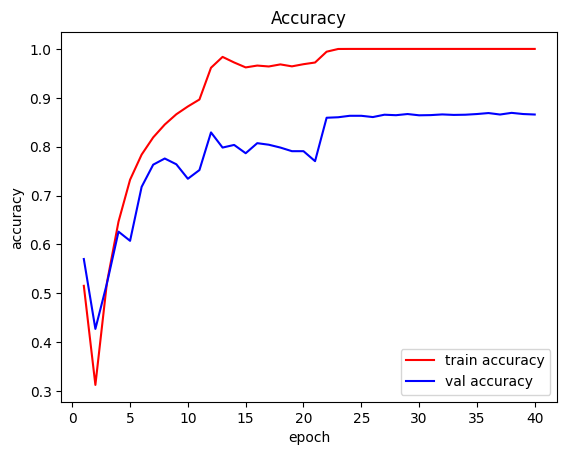

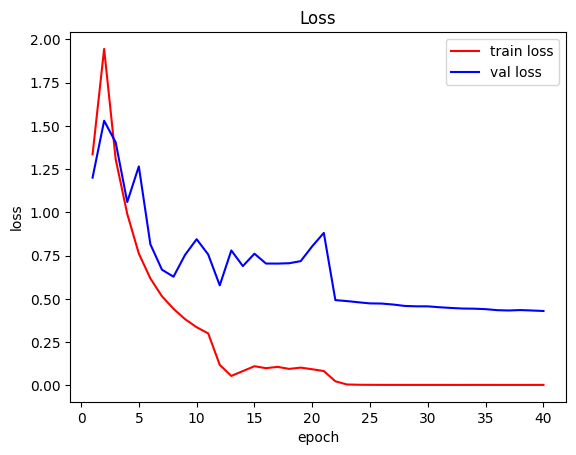

In [43]:
import matplotlib.pyplot as plt
# plot accuracy curve
plt.figure(0)
plt.plot(range(1,EPOCH+1,1), np.array(train_acc), 'r-', label= "train accuracy")
plt.plot(range(1,EPOCH+1,1), np.array(val_acc), 'b-', label= "val accuracy")
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
#plt.ylim(0.6, 1.1)
plt.legend()
plt.show()

# plot loss curve
plt.figure(1)
plt.plot(range(1,EPOCH+1,1), np.array(train_loss), 'r-', label= "train loss")
plt.plot(range(1,EPOCH+1,1), np.array(val_loss), 'b-', label= "val loss")
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# Different batchsize (256)
# Different base learning rate and update strategy
# Baseline + normalization + data augmentation
## EPOCH = 40
## pre_epoch = 0
## BATCH_SIZE = 256
## lr = 0.1, for epoch<10
## lr = 0.05, for 10<epoch<20
## lr = 0.01, for 20<epoch

In [44]:
# setting parameter
EPOCH = 40
pre_epoch = 0
BATCH_SIZE = 64
lr = 0.01
device = torch.device("cuda")

In [45]:
# data augmentation & normalization
mean= [0.49260563, 0.48348528, 0.44855368] #RGB
std= [0.2467772,  0.24288093, 0.26137766]
transform_train = transforms.Compose([
    # data augmentation
    transforms.RandomCrop(32, padding=4), #隨機採剪
    transforms.RandomHorizontalFlip(),   #隨機水平翻轉
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    # data normalization    # standardization: (image - train_mean) / train_std

])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    # data normalization    # standardization: (image - train_mean) / train_std

])

In [46]:
# learning rate shedule
def adjust_learning_rate(optim, epoch):
    # define your lr scheduler
    if epoch < 10:
        lr = 0.1
    elif epoch < 20:
        lr = 0.05
    else:
        lr = 0.01

    for param_group in optim.param_groups:
        param_group['lr'] = lr

In [47]:
#是否pretrain
#import torchvision.models as models
#net = models.resnet18(pretrained = False).to(device)
net = ResNet(ResBlock).to(device)

# 定義損失函數和優化方式
criterion = nn.CrossEntropyLoss()  #loss function
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4) #優化方式為mini-batch momentum-SGD，採用L2正則化（權重衰減）
schecdular = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.5,last_epoch=-1)
# train
if __name__ == "__main__":
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []
    for epoch in range(pre_epoch, EPOCH):
        net.train()
        sum1_loss, sum2_loss = 0.0, 0.0
        correct = 0.0
        total = 0.0
        print('\nEpoch: %d' % (epoch + 1))
        for i, traindata in enumerate(trainloader, 0):
            # prepare data
            length = len(trainloader)
            inputs, train_labels = traindata
            inputs, train_labels = inputs.to(device), train_labels.to(device)
            optimizer.zero_grad()

            # forward + backward
            train_outputs = net(inputs)
            trainloss = criterion(train_outputs, train_labels)
            trainloss.backward()
            optimizer.step()

            # 每訓練1個batch的loss和acc
            sum1_loss += trainloss.item()
            _, predicted = torch.max(train_outputs.data, 1)     # 取得分數最高的那個類 (outputs.data的index), train_outputs.data.shape is torch.Size([128, 10])
            # print(torch.max(train_outputs.data, 1)[1])
            total += train_labels.size(0)
            correct += predicted.eq(train_labels.data).cpu().sum()


        schecdular.step()
        writer.add_scalar("lr", optimizer.param_groups[0]['lr'], epoch)
        adjust_learning_rate(optimizer, epoch)
        print("learning rate: ",  optimizer.param_groups[0]['lr'])

        loss1 = sum1_loss / (i + 1) # i is equal to number of batches
        acc1 = correct / total
        print("Train loss: %.3f | Train acc: %.3f" % (loss1, acc1))
        train_loss.append(loss1)
        train_acc.append(acc1.item())

        # 每個epoch完用val驗證
        with torch.no_grad():
            correct = 0
            total = 0
            for j, valdata in enumerate(valloader, 0):
                net.eval()
                images, val_labels = valdata
                images, val_labels = images.to(device), val_labels.to(device)
                val_outputs = net(images)
                valloss = criterion(val_outputs, val_labels)

                sum2_loss += valloss.item()
                _, predicted = torch.max(val_outputs.data, 1)
                total += val_labels.size(0)
                correct += (predicted == val_labels).sum()

            loss2 = sum2_loss / (j + 1)
            acc2 = correct / total
            print("Val loss: %.3f | Val acc: %.3f" % (loss2, acc2))
            val_loss.append(loss2)
            val_acc.append(acc2.item())

    # 用test測試
    with torch.no_grad():
        correct = 0
        total = 0
        sum3_loss = 0.0
        for k, testdata in enumerate(testloader, 0):
            net.eval()
            imgs, test_labels = testdata
            imgs, test_labels = imgs.to(device), test_labels.to(device)
            test_outputs = net(imgs)
            testloss = criterion(test_outputs, test_labels)

            sum3_loss += testloss.item()
            _, predicted = torch.max(test_outputs.data, 1)
            total += test_labels.size(0)
            correct += (predicted == test_labels).sum()

        loss3 = sum3_loss / (k + 1)
        acc3 = correct / total
        print("Test loss: %.3f | Test acc: %.3f" % (loss3, acc3))


Epoch: 1
learning rate:  0.1
Train loss: 1.290 | Train acc: 0.530
Val loss: 1.183 | Val acc: 0.600

Epoch: 2
learning rate:  0.1
Train loss: 1.540 | Train acc: 0.466
Val loss: 1.216 | Val acc: 0.561

Epoch: 3
learning rate:  0.1
Train loss: 0.890 | Train acc: 0.685
Val loss: 0.922 | Val acc: 0.675

Epoch: 4
learning rate:  0.1
Train loss: 0.696 | Train acc: 0.758
Val loss: 1.095 | Val acc: 0.628

Epoch: 5
learning rate:  0.1
Train loss: 0.579 | Train acc: 0.798
Val loss: 1.295 | Val acc: 0.612

Epoch: 6
learning rate:  0.1
Train loss: 0.485 | Train acc: 0.832
Val loss: 0.678 | Val acc: 0.765

Epoch: 7
learning rate:  0.1
Train loss: 0.415 | Train acc: 0.854
Val loss: 0.731 | Val acc: 0.760

Epoch: 8
learning rate:  0.1
Train loss: 0.365 | Train acc: 0.874
Val loss: 0.702 | Val acc: 0.773

Epoch: 9
learning rate:  0.1
Train loss: 0.331 | Train acc: 0.885
Val loss: 0.644 | Val acc: 0.790

Epoch: 10
learning rate:  0.1
Train loss: 0.295 | Train acc: 0.898
Val loss: 0.719 | Val acc: 0.762

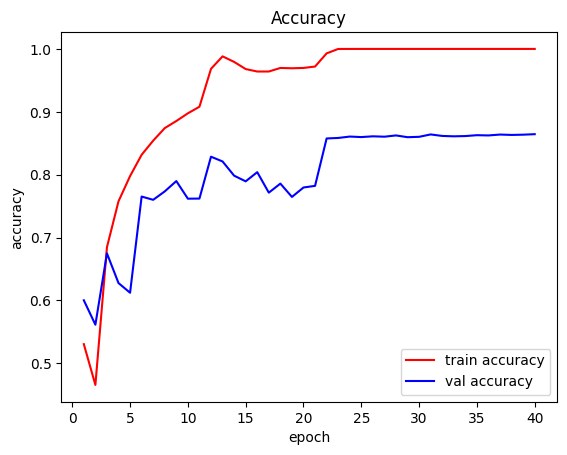

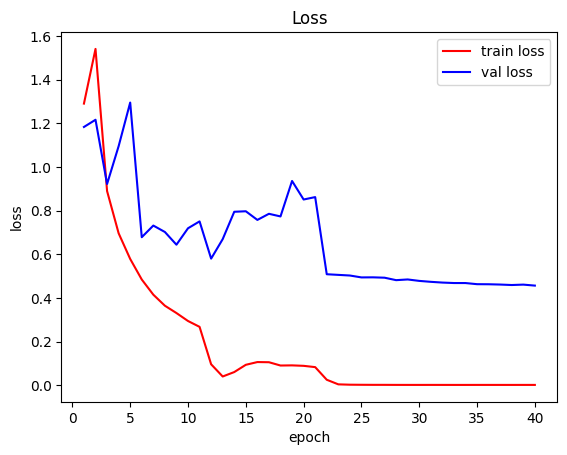

In [48]:
import matplotlib.pyplot as plt
# plot accuracy curve
plt.figure(0)
plt.plot(range(1,EPOCH+1,1), np.array(train_acc), 'r-', label= "train accuracy")
plt.plot(range(1,EPOCH+1,1), np.array(val_acc), 'b-', label= "val accuracy")
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
#plt.ylim(0.6, 1.1)
plt.legend()
plt.show()

# plot loss curve
plt.figure(1)
plt.plot(range(1,EPOCH+1,1), np.array(train_loss), 'r-', label= "train loss")
plt.plot(range(1,EPOCH+1,1), np.array(val_loss), 'b-', label= "val loss")
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()